In [1]:
import numpy as np
from scipy.stats import norm, johnsonsu, probplot, ks_2samp
import pandas as pd

from sqlalchemy.orm import sessionmaker
from sqlalchemy import text, bindparam

import matplotlib.pyplot as plt
import seaborn as sns

from gmot.data.DbAccessor import DBAccessor, GBPost

# Check Data

##  Get samples

In [2]:
db = DBAccessor()
db.prepare_connect(cf='../gmot/gb/config.ini', echo=False)

In [3]:
sql_stat = text("""
select
    gb_posts.meta_ids_name,
    gb_posts.stage_mode
from
    gb_posts
where
    gb_posts.is_valid_data = '0'
group by
    gb_posts.meta_ids_name,
    gb_posts.stage_mode
order by
    gb_posts.stage_mode,
    gb_posts.meta_ids_name
    """)

sql_sample = text("""
select
    gb_posts.user_id,
    gb_posts.final_score
from
    gb_posts,
    (select
        user_id,
        MAX(final_score) as best_score
    from
        gb_posts
    where
        meta_ids_name = :stag and 
        stage_mode = :mode and 
        is_valid_data = '0'
    group by
        user_id) max_post
where
    gb_posts.user_id = max_post.user_id and
    gb_posts.final_score = max_post.best_score and
    gb_posts.meta_ids_name = :stag and
    gb_posts.is_valid_data = '0'
order by
    gb_posts.final_score desc
    """ , bindparams=[bindparam('stag'), bindparam('mode')])

In [4]:
session_maker = sessionmaker(bind=db.engine)
session = session_maker()

In [5]:
rs_stat = session.execute(sql_stat).fetchall()
df_stat = pd.DataFrame(data=rs_stat, columns=['stag', 'smode'])

In [6]:
df_stage = df_stat[['stag', 'smode']]
list_stage = [(df_stage.iloc[rowi].stag, df_stage.iloc[rowi].smode) for rowi in df_stage.T]
list_stage_id = [f"{stag}_{smode}" for stag, smode in list_stage]

df_sample_byuser = None
for stag, smode in list_stage:
    rs_sample = session.execute(sql_sample, {'stag': stag, 'mode': smode}).fetchall()
    df_tmp = pd.DataFrame(data=rs_sample, columns=['user_id', f"{stag}_{smode}"])\
                .astype({'user_id': np.str, f"{stag}_{smode}": np.int64})
    if df_sample_byuser is not None:
        df_sample_byuser = pd.merge(df_sample_byuser, df_tmp, on='user_id', how='outer')
    else:
        df_sample_byuser = df_tmp
    
# session.flush()
session.commit()
session.close()

## Correct Data

In [7]:
def exclude_outliers_in_df(df, col, delf=True):
    Q1 = np.percentile(df[col].dropna(), 25) # 1st quartile (25%)
    Q3 = np.percentile(df[col].dropna(), 75) # 3rd quartile (75%)
    IQR = Q3 - Q1 # Interquartile range (IQR)
    outlier_step = 1.5 * IQR
    outlier_step_min = Q1 - outlier_step
    outlier_step_max = Q3 + outlier_step

    outlier_indices = df[(df[col] < outlier_step_min) | (df[col] > outlier_step_max)].index
    return df.drop(outlier_indices, axis=0).reset_index(drop=True) if delf else outlier_indices

for sid in list_stage_id:
    ex_ind = exclude_outliers_in_df(df_sample_byuser, sid, delf=False)
    df_sample_byuser.loc[ex_ind, sid] = np.nan # loc[ex_ind][sid]だとloc[ex_ind]の[sid]列のコピーに対する変更になっちゃうよ

## Inspect distribution

In [8]:
df_sample_byuser.filter(regex=("_b")).describe().round(2)

,光有利1_b,光有利2_b,水有利1_b,水有利2_b,混合火1_b,混合闇1_b,火有利1_b,火有利2_b,闇有利1_b,闇有利2_b,風有利1_b,風有利2_b
count,207.00,323.00,247.00,310.00,233.00,267.00,260.00,163.00,217.00,261.00,270.00,203.00
mean,119183.12,140798.45,112871.49,142249.47,116079.23,135210.86,122501.35,130835.67,115807.52,124506.56,119370.04,113466.90
std,17164.50,20783.65,18149.64,23226.68,17194.87,19086.40,18237.35,21018.40,17829.90,19808.26,20845.60,15251.05
min,74537.00,87472.00,62599.00,75621.00,71395.00,82443.00,72504.00,81284.00,66019.00,64746.00,64295.00,70760.00
25%,108967.50,126552.50,100996.00,129123.00,105377.00,124514.50,111219.50,116726.00,104568.00,109913.00,103042.50,103151.00
50%,121094.00,139980.00,114110.00,143239.00,116979.00,137615.00,126493.00,130715.00,117150.00,126600.00,120365.50,116077.00
75%,133070.00,155531.50,124360.00,159855.50,127958.00,149721.00,136499.75,145691.50,129673.00,139813.00,134726.50,124871.50
max,155160.00,190013.00,156859.00,188433.00,153887.00,174005.00,155077.00,172229.00,147789.00,163709.00,163175.00,142849.00


In [9]:
df_sample_byuser.filter(regex=("_n")).describe().round(2)

,光有利1_n,光有利2_n,水有利1_n,水有利2_n,混合火1_n,混合闇1_n,火有利1_n,火有利2_n,闇有利1_n,闇有利2_n,風有利1_n,風有利2_n
count,173.00,276.00,203.00,204.00,174.00,195.00,245.00,120.00,181.00,176.00,210.00,213.00
mean,67040.83,81976.05,63735.43,77729.10,64111.33,75278.63,70901.88,72941.28,69267.35,66206.28,64140.49,68202.39
std,10599.43,11904.89,12756.24,12401.52,8823.65,10601.71,10226.01,9529.64,8338.35,10278.00,11716.33,8806.82
min,39622.00,49368.00,30767.00,43120.00,39814.00,44193.00,42183.00,47150.00,46359.00,36516.00,31522.00,42250.00
25%,61881.00,75784.75,55608.00,69903.25,59060.00,68284.00,65621.00,67566.75,64051.00,61600.25,57507.00,63070.00
50%,69349.00,85289.50,65973.00,79807.50,64974.00,77310.00,73228.00,73789.00,70093.00,68632.50,65771.50,70352.00
75%,74725.00,92290.50,72140.50,87529.25,70182.50,83277.00,78267.00,78664.00,74944.00,73815.00,72754.00,74781.00
max,87092.00,96416.00,96519.00,96270.00,83161.00,96051.00,90907.00,96170.00,85675.00,85641.00,86938.00,84451.00


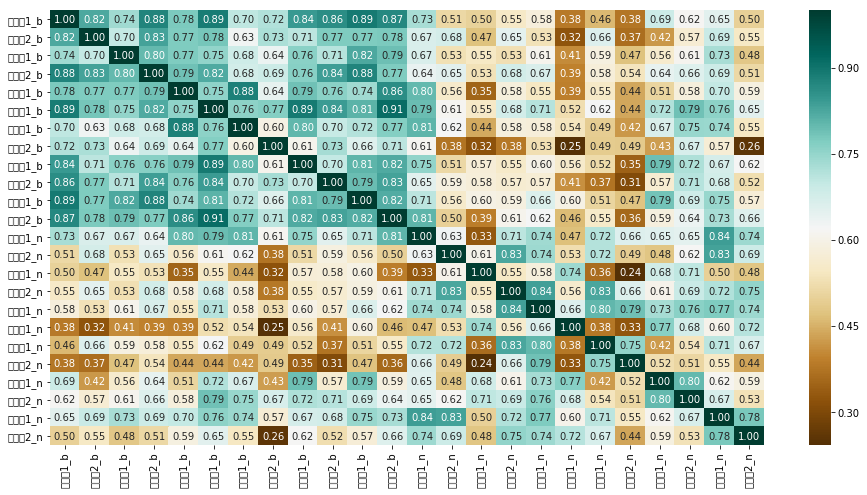

In [10]:
df_comp = df_sample_byuser.dropna()
plt.figure(figsize=(16, 8))
g = sns.heatmap(df_comp.corr(),cmap='BrBG',annot=True, fmt = ".2f")

In [11]:
df_comp_b = df_sample_byuser[list_stage_id[:12]].dropna()
df_comp_n = df_sample_byuser[list_stage_id[12:]].dropna()

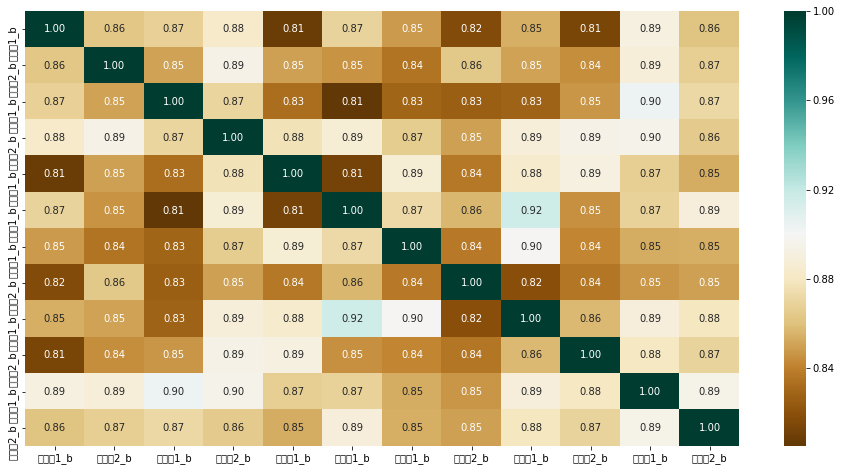

In [12]:
plt.figure(figsize=(16, 8))
g = sns.heatmap(df_comp_b.corr(),cmap='BrBG',annot=True, fmt = ".2f", center=0.9)

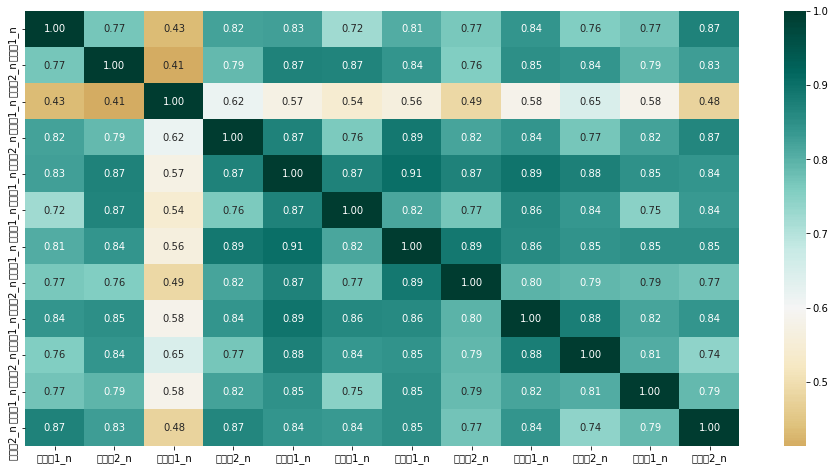

In [13]:
plt.figure(figsize=(16, 8))
g = sns.heatmap(df_comp_n.corr(), cmap='BrBG', annot=True, fmt = ".2f", center=0.6)

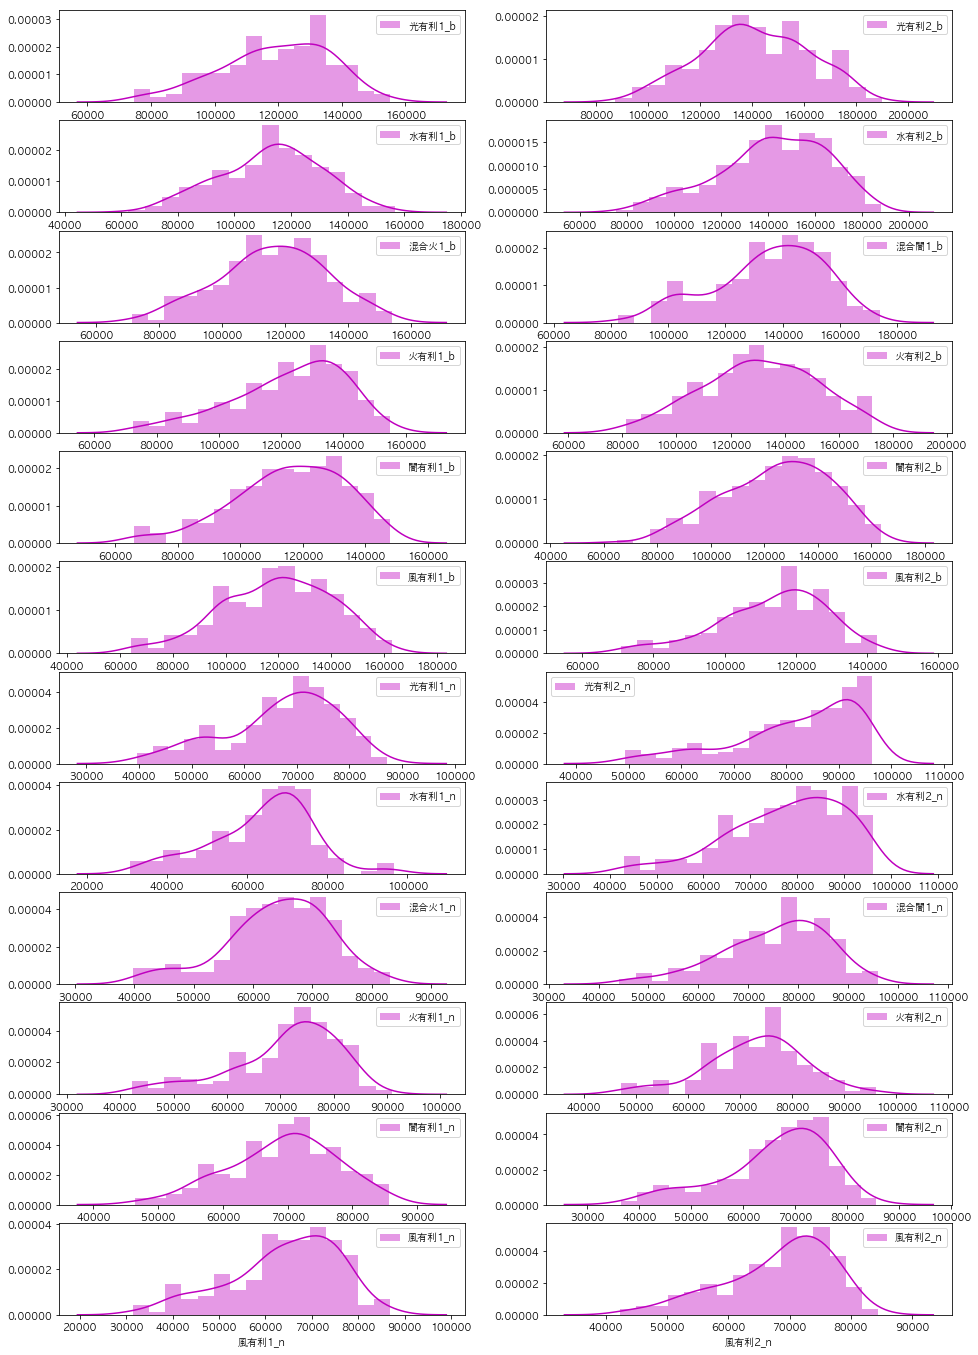

In [14]:
# dataset distribution
font = {'family': 'AppleGothic'}
plt.rc('font', **font)
fig = plt.figure(figsize=(16, 24))
for i, sid in enumerate(list_stage_id):
    plt.subplot(12, 2, i + 1)
    g = sns.distplot(df_sample_byuser[sid].dropna(), color="m", bins=16, label=f"{sid}")
    g = g.legend(loc="best")

# Attempt: Stastical Estimator

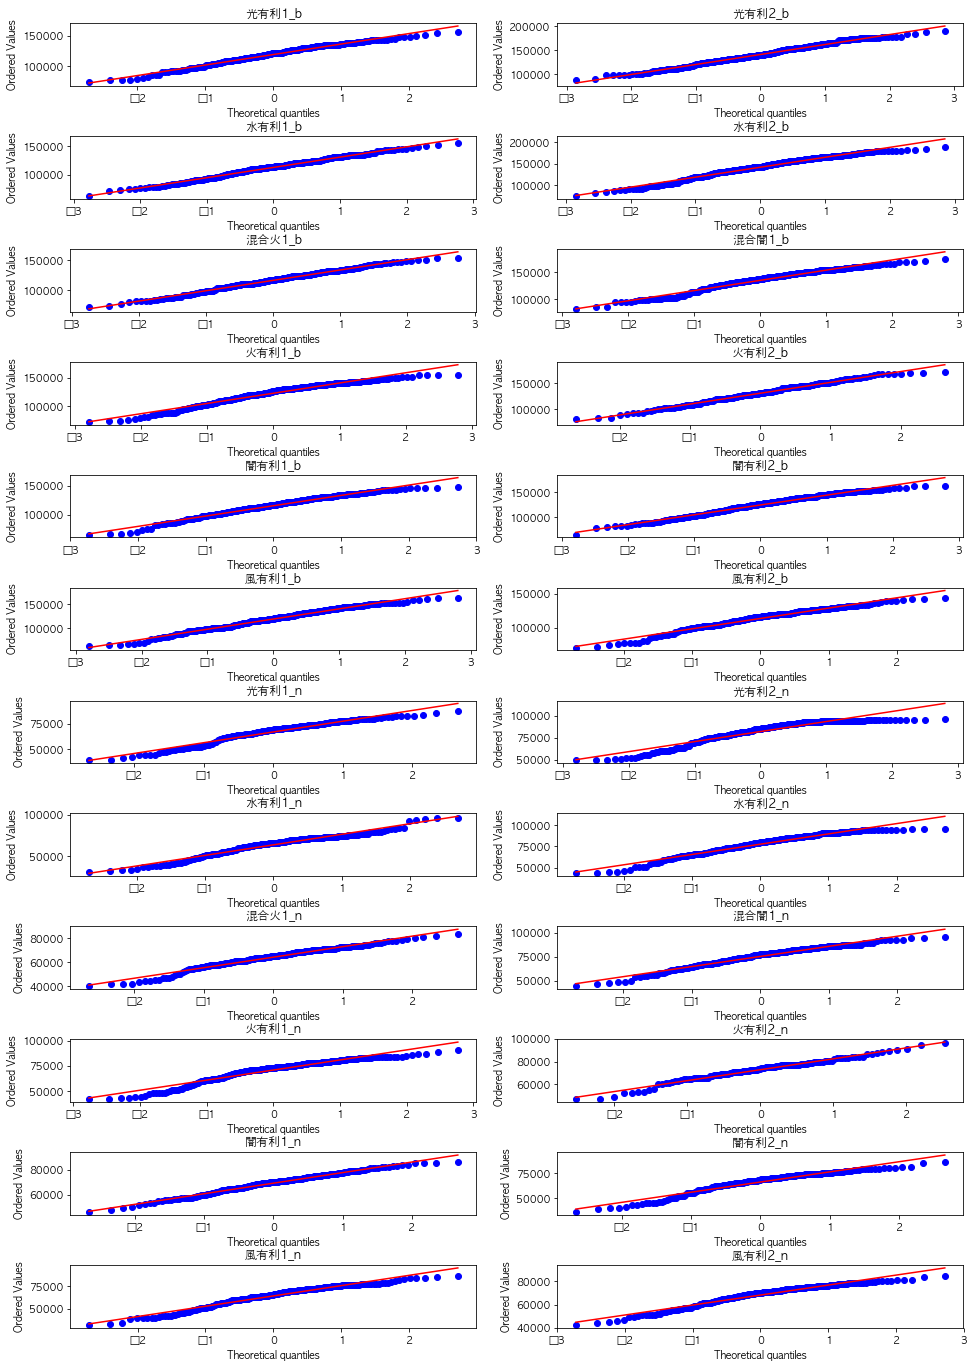

In [15]:
# distribution-test qqplot
fig = plt.figure(figsize=(16, 24))
for i, sid in enumerate(list_stage_id):
    sample = df_sample_byuser[sid].dropna()
    plt.subplot(12, 2, i + 1)
    g = probplot(sample, dist='norm', plot=plt)
    plt.title(f"{sid}")
    plt.subplots_adjust(wspace=0.2, hspace=0.8)

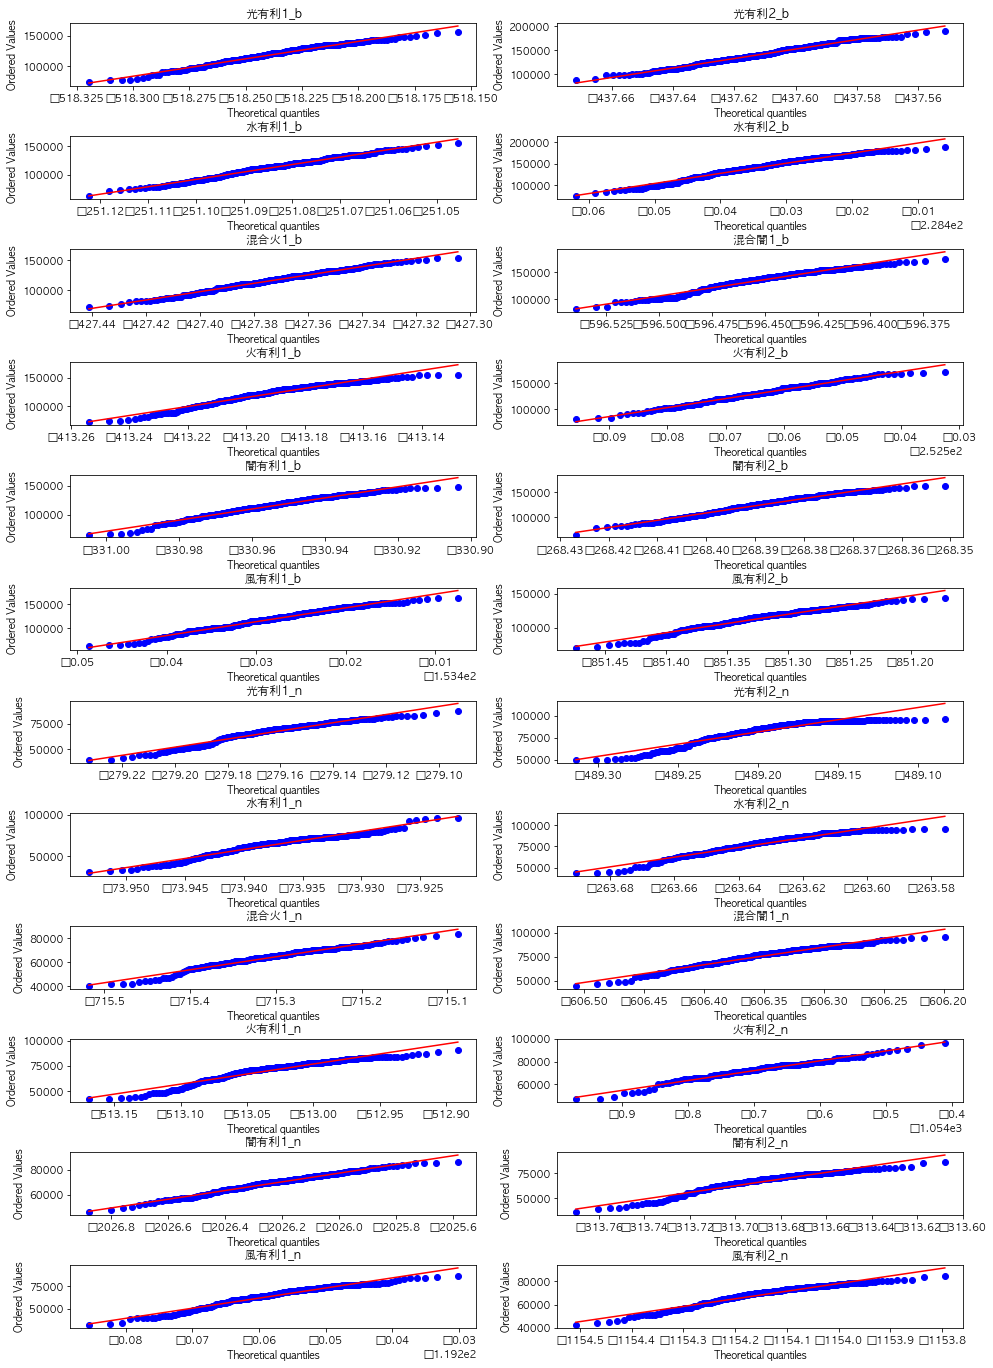

In [16]:
# distribution-test qqplot
fig = plt.figure(figsize=(16, 24))
for i, sid in enumerate(list_stage_id):
    sample = df_sample_byuser[sid].dropna()
    plt.subplot(12, 2, i + 1)
    g = probplot(sample, dist='johnsonsu', plot=plt, sparams=(sample.mean(), sample.std()))
    # default of pandas.std is unbiased variance / as with scipy, bessel's correction is considered
    plt.title(f"{sid}")
    plt.subplots_adjust(wspace=0.2, hspace=0.8)

## Define destribution

In [17]:
# define destribution
nrvs = {}
jrvs = {}
for i, sid in enumerate(list_stage_id):
    nrvs[sid] = norm(*norm.fit(df_sample_byuser[sid].dropna())) # fit return(avg, std)
    jrvs[sid] = johnsonsu(*johnsonsu.fit(df_sample_byuser[sid].dropna())) # fit return(avg, std, skew, krt)

In [ ]:
'stat:{}'.format(rvs.stats(moments='mvsk') for rvs in jrvs)

## Hypothesis Test

In [18]:
# Kolmogorov–Smirnov test
list_vs_norm = []
list_vs_johnson = []
rdv_size = 100000
for i, sid in enumerate(list_stage_id):
    vs_norm = []
    vs_johnson = []
    for i in range(1, 10):
        vs_norm.append(ks_2samp(df_sample_byuser[sid].dropna(), nrvs[sid].rvs(size=rdv_size)).pvalue)
        vs_johnson.append(ks_2samp(df_sample_byuser[sid].dropna(), jrvs[sid].rvs(size=rdv_size)).pvalue)
    list_vs_norm.append(np.array(vs_norm).mean())
    list_vs_johnson.append(np.array(vs_johnson).mean())

df_ht = pd.DataFrame(
    data=np.array((list_stage_id, list_vs_norm, list_vs_johnson, np.subtract(list_vs_norm, list_vs_johnson))).T,
    columns = ['sid', 'vs_norm', 'vs_jnsn', 'diff'])\
        .astype({'sid': np.str, 'vs_norm': np.float64, 'vs_jnsn': np.float64, 'diff': np.float64})
df_ht.style.format({'vs_norm' : "{:.3f}", 'vs_jnsn' : "{:.3f}", 'diff' : "{:.3f}"})\
            .applymap(lambda val: 'color: {}'.format('red' if val < 0 else 'blue'),
                      subset=pd.IndexSlice[:, ['diff']])

,sid,vs_norm,vs_jnsn,diff
0,光有利1_b,0.315,0.739,-0.423
1,光有利2_b,0.625,0.615,0.009
2,水有利1_b,0.433,0.878,-0.445
3,水有利2_b,0.188,0.842,-0.654
4,混合火1_b,0.915,0.997,-0.082
5,混合闇1_b,0.146,0.713,-0.566
6,火有利1_b,0.027,0.847,-0.820
7,火有利2_b,0.573,0.763,-0.190
8,闇有利1_b,0.464,0.944,-0.481
9,闇有利2_b,0.523,0.811,-0.288


In [19]:
df_ht.vs_norm.mean(), df_ht.vs_jnsn.mean()

(0.291197029556804, 0.7705204113869026)

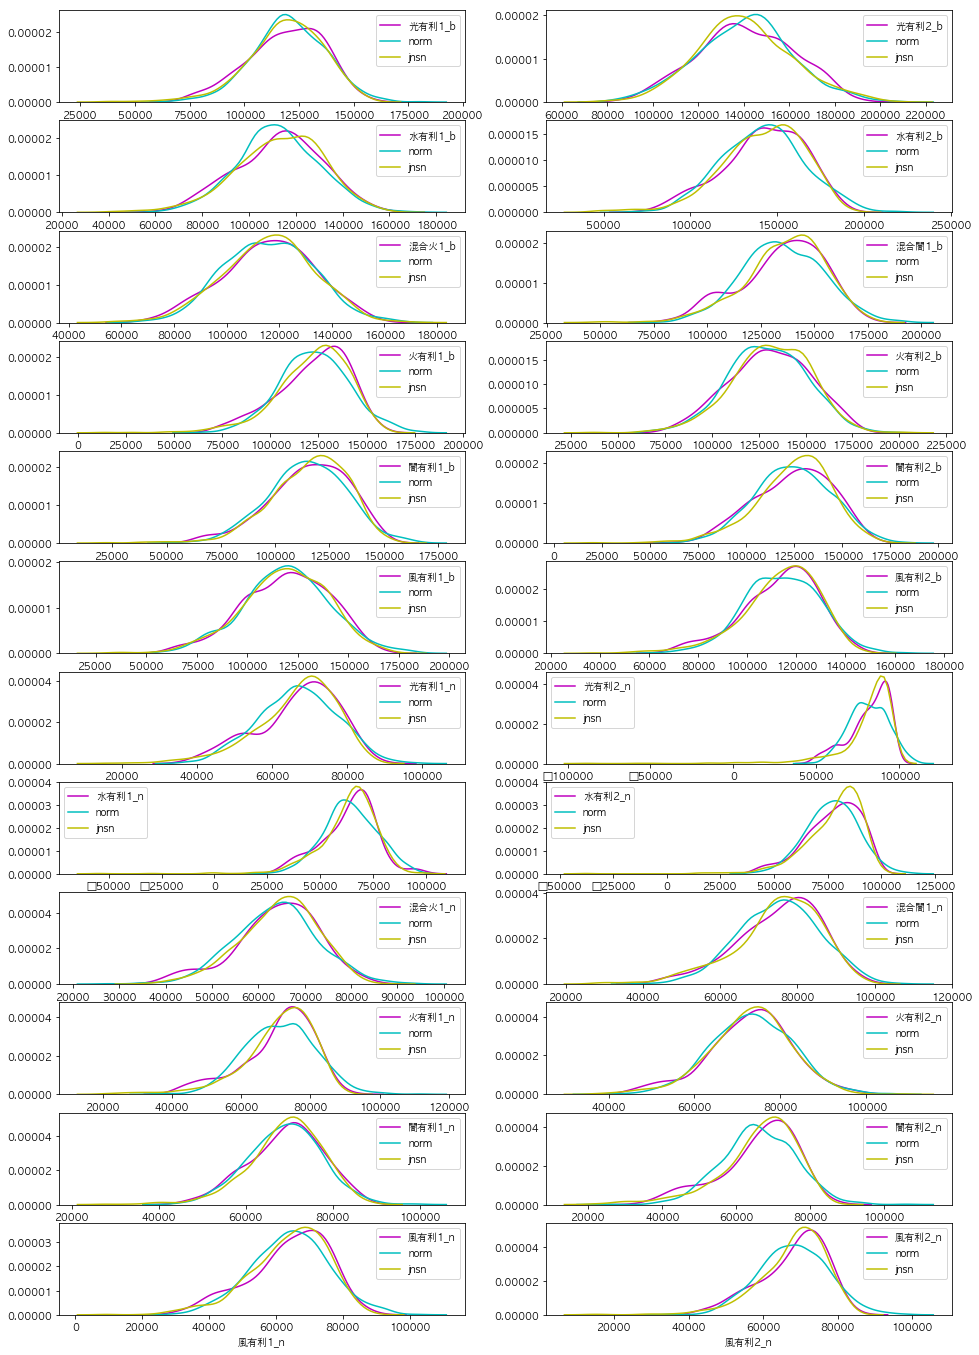

In [20]:
# confirm matching with dataset distribution
font = {'family': 'AppleGothic'}
plt.rc('font', **font)
fig = plt.figure(figsize=(16, 24))
for i, sid in enumerate(list_stage_id):
    plt.subplot(12, 2, i + 1)
    g = sns.distplot(df_sample_byuser[sid].dropna(), color="m", hist=False, label=f"{sid}")
    g = sns.distplot(nrvs[sid].rvs(size=1000), color="c", hist=False, label='norm')
    g = sns.distplot(jrvs[sid].rvs(size=1000), color="y", hist=False, label='jnsn')
    g = g.legend(loc="best")

## Define Estimator

In [21]:
def estimate_score(rvs, sid, bscr):
    sfq = rvs[sid].sf(x=bscr)
    escr = [np.round(rvs[sid].isf(q=sfq), 0) for sid in list_stage_id]
    return sfq, escr

# try
sfq, escr_stat = estimate_score(jrvs, '光有利2_b', 175000)
df_escr_stat = pd.DataFrame(data=escr_stat, columns=['escr_stat'])
result = pd.concat(objs=(df_stage, df_escr_stat), axis=1)
print(f"上位{sfq*100:0.2f}％に位置")
result

上位4.93％に位置


,stag,smode,escr_stat
0,光有利1,b,144485.0
1,光有利2,b,175000.0
2,水有利1,b,141337.0
3,水有利2,b,175677.0
4,混合火1,b,143168.0
5,混合闇1,b,162302.0
6,火有利1,b,147294.0
7,火有利2,b,164059.0
8,闇有利1,b,141191.0
9,闇有利2,b,153907.0


In [22]:
# for rowi in df_comp:
df_result = None
sr_user = df_comp.iloc[0]
for sid in list_stage_id:
    sfq, escr_stat = estimate_score(jrvs, sid ,sr_user[sid])
    
    df_escr_stat = pd.DataFrame(data=escr_stat, columns=[f"e{sid}"], index=list_stage_id)
    if df_result is not None:
        df_result = pd.concat(objs=[df_result, df_escr_stat], axis=1)
    else:
        df_result = pd.concat(objs=[sr_user.T.drop('user_id'), df_escr_stat], axis=1)
        df_result.columns = np.append(['GT'], df_result.columns[1:])

df_result

,GT,e光有利1_b,e光有利2_b,e水有利1_b,e水有利2_b,e混合火1_b,e混合闇1_b,e火有利1_b,e火有利2_b,e闇有利1_b,...,e水有利1_n,e水有利2_n,e混合火1_n,e混合闇1_n,e火有利1_n,e火有利2_n,e闇有利1_n,e闇有利2_n,e風有利1_n,e風有利2_n
光有利1_b,154472,154472.0,149037.0,145722.0,145441.0,150306.0,146276.0,148566.0,147405.0,149279.0,...,131611.0,128764.0,129413.0,129712.0,129792.0,132808.0,145212.0,144449.0,138269.0,130361.0
光有利2_b,183068,193571.0,183068.0,177133.0,176645.0,185431.0,178103.0,182205.0,180106.0,183516.0,...,155024.0,151074.0,151962.0,152373.0,152482.0,156730.0,176249.0,174938.0,164885.0,153272.0
水有利1_b,142928,154716.0,147278.0,142928.0,142565.0,148980.0,143647.0,146653.0,145121.0,147602.0,...,125710.0,122455.0,123192.0,123532.0,123622.0,127098.0,142270.0,141291.0,133593.0,124273.0
水有利2_b,176870,187929.0,181320.0,177220.0,176870.0,182876.0,177909.0,180741.0,179308.0,181618.0,...,159226.0,155498.0,156351.0,156743.0,156847.0,160784.0,176585.0,175631.0,167821.0,157593.0
混合火1_b,150527,156069.0,148886.0,144697.0,144349.0,150527.0,145389.0,148283.0,146807.0,149198.0,...,128213.0,125113.0,125815.0,126139.0,126224.0,129537.0,144065.0,143124.0,135743.0,126844.0
混合闇1_b,164060,171882.0,166735.0,163518.0,163242.0,167952.0,164060.0,166282.0,165159.0,166968.0,...,149202.0,146200.0,146888.0,147204.0,147288.0,150454.0,163018.0,162266.0,156078.0,147889.0
火有利1_b,150585,155078.0,150955.0,148307.0,148078.0,151942.0,148757.0,150585.0,149664.0,151145.0,...,135952.0,133253.0,133875.0,134160.0,134235.0,137066.0,147891.0,147264.0,141997.0,134775.0
火有利2_b,168567,180073.0,171145.0,165953.0,165521.0,173183.0,166809.0,170397.0,168567.0,171533.0,...,145612.0,141805.0,142665.0,143063.0,143169.0,147240.0,165170.0,164004.0,154884.0,143930.0
闇有利1_b,145607,150267.0,145386.0,142340.0,142080.0,146539.0,142853.0,144957.0,143893.0,145607.0,...,128836.0,126014.0,126660.0,126957.0,127036.0,130014.0,141868.0,141157.0,135313.0,127601.0
闇有利2_b,163042,165645.0,159249.0,155358.0,155028.0,160741.0,156008.0,158696.0,157333.0,159534.0,...,138868.0,135555.0,136310.0,136658.0,136750.0,140262.0,154760.0,153865.0,146634.0,137413.0


## Attempt: MLRegression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV

source_col = '光有利1_b'
df_comp.iloc[:, :13].describe()

,光有利1_b,光有利2_b,水有利1_b,水有利2_b,混合火1_b,混合闇1_b,火有利1_b,火有利2_b,闇有利1_b,闇有利2_b,風有利1_b,風有利2_b
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,124677.476190,152998.571429,118432.428571,154357.142857,123763.952381,147712.238095,132780.476190,136942.904762,125025.857143,134988.476190,127773.761905,118301.571429
std,12315.097826,17137.475224,13763.884941,12579.182594,10127.129744,11360.959484,8562.299578,14392.731568,10519.984103,12863.880393,12620.167312,10160.262391
min,100332.000000,122228.000000,76420.000000,133056.000000,107410.000000,126962.000000,119857.000000,112095.000000,105807.000000,106856.000000,107579.000000,101655.000000
25%,121702.000000,140600.000000,114021.000000,143687.000000,120215.000000,140186.000000,127090.000000,129230.000000,115680.000000,129935.000000,120839.000000,112736.000000
50%,123890.000000,158233.000000,117279.000000,156287.000000,123257.000000,148257.000000,133967.000000,134457.000000,125240.000000,138143.000000,126586.000000,119154.000000
75%,130600.000000,163169.000000,123083.000000,161286.000000,127958.000000,156390.000000,137424.000000,143401.000000,130970.000000,139830.000000,131909.000000,123159.000000
max,154472.000000,183068.000000,144350.000000,176870.000000,150527.000000,170180.000000,150585.000000,168567.000000,145607.000000,163042.000000,157438.000000,139277.000000


In [24]:
df_comp.iloc[:, 13:].describe()

,光有利1_n,光有利2_n,水有利1_n,水有利2_n,混合火1_n,混合闇1_n,火有利1_n,火有利2_n,闇有利1_n,闇有利2_n,風有利1_n,風有利2_n
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,75239.666667,91939.714286,73311.380952,87358.619048,70085.761905,84417.952381,79145.666667,78431.238095,77571.523810,75261.333333,72749.333333,75088.476190
std,6052.648076,3306.989358,9277.708141,6039.204778,4837.434340,4436.028601,4648.215952,6896.385393,4887.750921,3951.827126,6516.618765,4769.629709
min,63693.000000,84422.000000,54842.000000,74656.000000,59695.000000,78548.000000,67471.000000,63529.000000,70079.000000,65959.000000,56984.000000,63845.000000
25%,72385.000000,91034.000000,69954.000000,83824.000000,68331.000000,81228.000000,77420.000000,76719.000000,72636.000000,73132.000000,69317.000000,70339.000000
50%,74040.000000,92988.000000,72216.000000,89208.000000,71555.000000,83386.000000,79012.000000,78237.000000,78666.000000,74984.000000,73955.000000,76176.000000
75%,79881.000000,94376.000000,74082.000000,91958.000000,73169.000000,87565.000000,82306.000000,82070.000000,80660.000000,78731.000000,76737.000000,78613.000000
max,85065.000000,95205.000000,96519.000000,94951.000000,77291.000000,92264.000000,86623.000000,90655.000000,85620.000000,81208.000000,84232.000000,81099.000000


In [25]:
classifier_models = {
    'LR' : MultiOutputRegressor(LogisticRegression()),
    'SVR': MultiOutputRegressor(SVR()),
    'LinearSVR': MultiOutputRegressor(LinearSVR()),
    'KNeighbors': MultiOutputRegressor(KNeighborsRegressor()),
    'DecisionTree': MultiOutputRegressor(DecisionTreeRegressor()),
    'RandomForest': MultiOutputRegressor(RandomForestRegressor()),
    'AdaBoost': MultiOutputRegressor(AdaBoostRegressor()),
    'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor()),
    'MLP': MLPRegressor(solver='lbfgs', early_stopping=True,
                                   hidden_layer_sizes=(200, 100), random_state=0),
    }

results = []
names = []
for name, model in classifier_models.items():
    result = cross_val_score(model, df_comp[source_col].values.reshape(-1, 1), df_comp.iloc[:, 1:], cv=3)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i], results[i].mean())

LR -5.33294995285618
SVR -2.0604356368941272
LinearSVR -5.849332013651015
KNeighbors -1.330282554959383
DecisionTree -2.5879277204070337
RandomForest -1.9961072178231252
AdaBoost -2.4347900743642783
GradientBoosting -2.575149989745037
MLP -0.6775686723164919


In [26]:
gs_params = {
    'MLP' : {
            'hidden_layer_sizes': [(100,), (200,), (100,100), (200,100), (200,100,100)],
            'learning_rate': ['invscaling', 'adaptive', 'constant'],
            'activation': ['identity', 'relu'],
            'solver': ['lbfgs', 'adam'],
        },
    'RandomForest': {
            'estimator__n_estimators': np.linspace(100, 200, num=3, dtype=np.int),
            'estimator__max_depth': [5, 10, 25],
            'estimator__min_samples_split': [5, 10, 25],
            'estimator__random_state': [0],
        },
    'KNeighbors': {
            'estimator__n_neighbors': [1, 3, 5],
            'estimator__weights': ['uniform', 'distance'],
            'estimator__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        }
}

In [27]:
b_params = \
{'KNeighbors': {'estimator__algorithm': 'auto',
  'estimator__n_neighbors': 1,
  'estimator__weights': 'uniform'},
 'MLP': {'activation': 'identity',
  'hidden_layer_sizes': (100,),
  'learning_rate': 'invscaling',
  'solver': 'lbfgs'},
 'RandomForest': {'estimator__max_depth': 10,
  'estimator__min_samples_split': 5,
  'estimator__n_estimators': 150,
  'estimator__random_state': 0}}

# Verification

In [48]:
def rms_error(x_arr, y_arr): # 平方根平均二乗誤差 RootMeanSquared-error
    err = 0.0
    for x, y in zip(x_arr, y_arr):
        err += 0.5 * (y - x)**2
    return np.sqrt(2 * err / len(x_arr))

In [29]:
from sklearn.model_selection import train_test_split
x = df_comp[source_col].values.reshape(-1, 1)
_y = df_comp.iloc[:, 1:].values
X_train, X_test, y_train, y_test = train_test_split(x, _y, test_size=1, train_size=x.size-1)

In [46]:
sfq, escr = estimate_score(jrvs, source_col, X_test)
stat_esterr = rms_error(y_test.flatten(), np.array(escr).flatten())
stat_esterr

7298.223459628149

In [49]:
for model_name in ('KNeighbors', 'RandomForest', 'MLP'):
    classifier_models[model_name].set_params(**b_params[model_name])
    model = classifier_models[model_name].fit(X_train, y_train)
    result = cross_val_score(model, x, _y, cv=3)
    error = rms_error(y_test.flatten(), model.predict(X_test).flatten())
    print("{}: {} / {}".format(model_name, result.mean(), error))

KNeighbors: -2.5879277204070337 / 0.0
RandomForest: -1.6829386275749172 / 2876.1334838785933
MLP: -0.6775655392221118 / 4763.563533528132


In [50]:
predict = model.predict([[df_result.loc[source_col, 'GT']]])
predict

array([[154472.11770663, 189089.86651357, 146822.9136802 ,
        190865.26605581, 152278.17333645, 182479.52685493,
        163236.22545722, 169620.18066388, 154156.01902171,
        167329.97654483, 158257.30597948, 146216.36421856,
         92438.75787291, 112869.17478459,  90506.95511091,
        107337.5608974 ,  86196.05735268, 103619.26262651,
         97102.58907049,  96217.08573045,  95519.13049625,
         92704.13600685,  89571.98232975,  92075.68567821]])

In [53]:
np.array(escr).flatten()

array([125336., 146505., 118620., 150968., 121467., 142536., 129914.,
       137332., 122573., 131572., 126520., 119209.,  71374.,  88822.,
        68272.,  83275.,  67258.,  79339.,  75221.,  75934.,  72100.,
        70492.,  68784.,  71870.])

In [61]:
for rvs in jrvs.values():
    print(rvs.stats(moments='mvsk'))

(array(119166.12005777), array(2.9862138e+08), array(-0.60696843), array(0.66795603))
(array(140798.4140625), array(3.35617246e+08), array(16777216.), array(-8.4442493e+14))
(array(112889.87636473), array(3.29150263e+08), array(-0.27757404), array(0.14436119))
(array(142200.99366039), array(5.55068248e+08), array(-0.74983123), array(1.02166262))
(array(116097.26111662), array(2.95255638e+08), array(-0.25334353), array(0.12200406))
(array(135206.11442923), array(3.74683945e+08), array(-0.81898285), array(1.22285898))
(array(122488.8106777), array(3.47503001e+08), array(-1.05227311), array(2.03613123))
(array(130844.72124499), array(4.40287339e+08), array(-0.22895279), array(0.0984946))
(array(115754.20572594), array(3.27354701e+08), array(-0.79880741), array(1.16100301))
(array(124488.68281383), array(3.99231018e+08), array(-0.583752), array(0.61653987))
(array(119417.61829072), array(4.38075132e+08), array(-0.45725598), array(0.38157329))
(array(113482.38293458), array(2.34693797e+08),

In [60]:
jrvs

{'光有利1_b': <scipy.stats._distn_infrastructure.rv_frozen at 0x115c6b6d8>,
 '光有利1_n': <scipy.stats._distn_infrastructure.rv_frozen at 0x1148d3b70>,
 '光有利2_b': <scipy.stats._distn_infrastructure.rv_frozen at 0x114bb7048>,
 '光有利2_n': <scipy.stats._distn_infrastructure.rv_frozen at 0x113e39fd0>,
 '水有利1_b': <scipy.stats._distn_infrastructure.rv_frozen at 0x115b18cf8>,
 '水有利1_n': <scipy.stats._distn_infrastructure.rv_frozen at 0x113e39470>,
 '水有利2_b': <scipy.stats._distn_infrastructure.rv_frozen at 0x114804908>,
 '水有利2_n': <scipy.stats._distn_infrastructure.rv_frozen at 0x11489f198>,
 '混合火1_b': <scipy.stats._distn_infrastructure.rv_frozen at 0x113e12cc0>,
 '混合火1_n': <scipy.stats._distn_infrastructure.rv_frozen at 0x114915518>,
 '混合闇1_b': <scipy.stats._distn_infrastructure.rv_frozen at 0x113e124e0>,
 '混合闇1_n': <scipy.stats._distn_infrastructure.rv_frozen at 0x10c3da5c0>,
 '火有利1_b': <scipy.stats._distn_infrastructure.rv_frozen at 0x115af27f0>,
 '火有利1_n': <scipy.stats._distn_infrastructure.rv_fr

*Adopt statstical estimator*